In [1]:
###########
#Usual libraries
###########
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from matplotlib import dates
import math
import netCDF4 as NC4
import os
import datetime
from scipy.signal import detrend,welch
import numpy.matlib
from numpy.fft import ifft2
from numpy import squeeze
import xarray as xr    # only used for filters: this dependency should be removed
from scipy.interpolate import griddata

###########
#Additionals functions
###########
from scipy.io import loadmat
from scipy.stats.distributions import chi2
from scipy.interpolate import LinearNDInterpolator

###########
#Wave physics and simulation functions
###########

from surface_simulation_functions import *
from wave_physics_functions import *



import warnings

warnings.filterwarnings("ignore")

mpl.rcParams.update({'figure.figsize':[10,6],'font.size': 14,'savefig.facecolor':'white'})

## Get 2D (frequency,direction) spectrum from buoy 'first 5' moments data

### Read ncfile

In [2]:
# %run surface_simulation_functions.py

In [3]:
path_buoy='./'
file_buoy='CDIP46214_2023_avg1h.nc'
# file_buoy='CDIP51201_IG2012_avg3h.nc'

# it=103 # choice of time index ... 
# it=351 # choice of time index 

# ################# Reads all the variables we need from the NetCDF file
nc_buoy=NC4.Dataset(os.path.join(path_buoy+file_buoy))
print("Variables disponibles :")
for var_name in nc_buoy.variables:
    print(var_name)
    
lat=nc_buoy.variables['latitude'][:,0]
lon=nc_buoy.variables['longitude'][:,0]


fb=nc_buoy.variables['frequency'][:]
timeb=nc_buoy.variables['time'][:]
ntimeb=len(timeb)

f2b=nc_buoy.variables['frequency2'][:]
f1b=nc_buoy.variables['frequency1'][:]
th1mb=nc_buoy.variables['th1m'][:,0,:]
sth1mb=nc_buoy.variables['sth1m'][:,0,:]
th2mb=nc_buoy.variables['th2m'][:,0,:]
sth2mb=nc_buoy.variables['sth2m'][:,0,:]
freqb=(f1b+f2b)/2.
dfb=f2b-f1b
Efb=nc_buoy.variables['ef'][:,0,:]



df2b=np.tile(dfb.T,(ntimeb,1))
print('For your information this is the shape of the df2b array:',np.shape(df2b))
print('Shape of Efb',np.shape(Efb))
ifmaxb=len(fb)-1
# computes surface elevation variance
E=(np.sum(Efb[:,0:ifmaxb]*df2b[:,0:ifmaxb],axis=1))


d2r=np.pi/180# deg. to radians conversion factor

Variables disponibles :
time
station
string16
station_name
longitude
latitude
frequency
frequency1
frequency2
ef
th1m
sth1m
th2m
sth2m
For your information this is the shape of the df2b array: (25211, 64)
Shape of Efb (25211, 64)


2023-04-27T22:39:00.000000000 1 seconds
range of time values for buoy  11713.875  to 12763.458333333489 . Time of sentinel 2: 12169.94375
The E(f) spectrum has  64 frequencies.
For your information this is the shape of the Efth array: (64, 72)
Array: (64,)
Checking that the Hs is correct for Efth: 1.308064834980133


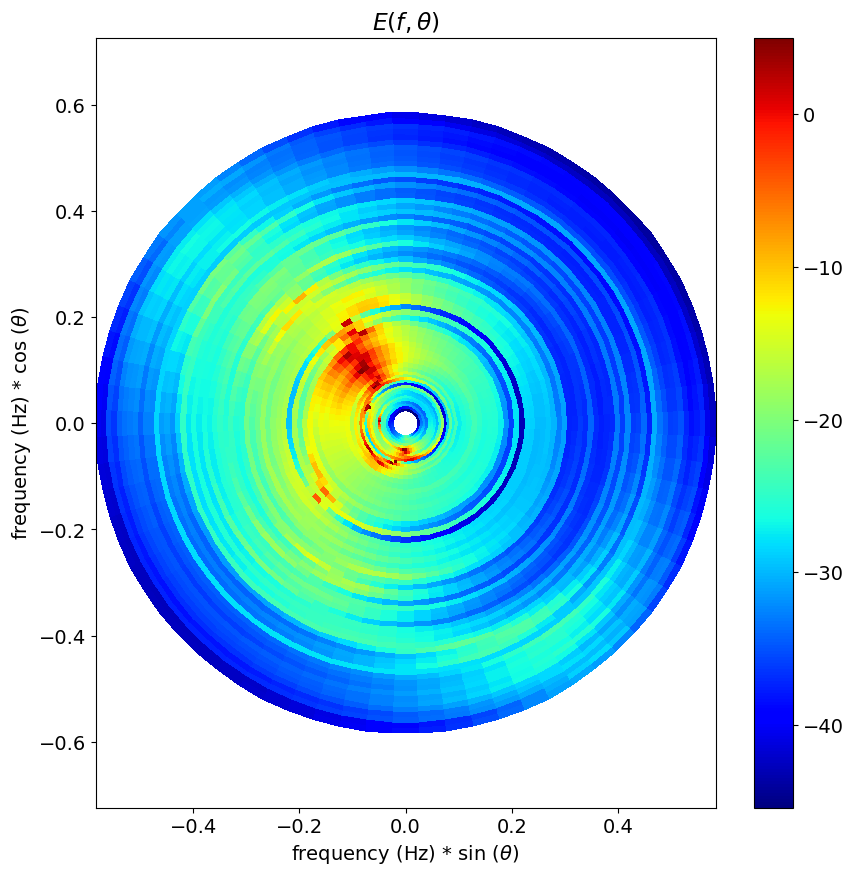

In [4]:
# time step selction
t1=np.datetime64('2023-04-27 22:39', 'ns')
t0=np.datetime64('1990-01-01 00:00', 'ns')
print(t1,np.timedelta64(1, 's'))

tdiff=(t1-t0);
tds = tdiff / np.timedelta64(1, 's')/86400
print('range of time values for buoy ',nc_buoy.variables['time'][0],' to',nc_buoy.variables['time'][-1],'. Time of sentinel 2:',tds)
# Now finds indices of points that are less than 6 hours from the S2 image
indt=np.where(nc_buoy.variables['time'] > tds  )[0]
it=indt[0]

# it=103 # choice of time index ... 
# it=351 # choice of time index 


# Directionnal wave spectrum

a0=Efb[it,:]
print('The E(f) spectrum has ',np.size(a0),'frequencies.')
#print('Hs: ',Hsb[it],' m.')
m1=abs(1.-0.5*(sth1mb[it,:]*d2r)**2)
m2=abs(1.-2*(sth2mb[it,:]*d2r)**2)

a1=np.cos(th1mb[it,:]*d2r)*m1 # Directional distribution 2*pi periodic component (cosine component)
b1=np.sin(th1mb[it,:]*d2r)*m1 # Directional distribution 2*pi periodic component (sine component)
a2=np.cos(2*th2mb[it,:]*d2r)*m2 # Directional distribution pi periodic component (cosine component)
b2=np.sin(2*th2mb[it,:]*d2r)*m2 # Directional distribution pi periodic component (sine component)

ndirs=36*2
dth=np.pi*2/ndirs
nfreq = np.size(a0)
[Efth,D,dirs] = buoy_spectrum2d(a0,a1,a2,b1,b2,ndirs) #Here the MEM method that estimate the 2D spectrum from the first 5 Fourier Parameters
print('For your information this is the shape of the Efth array:',np.shape(Efth))

f2D=np.tile(freqb,(ndirs,1)).T
xf=f2D*np.tile(np.cos(dirs*d2r).T,(nfreq,1))
yf=f2D*np.tile(np.sin(dirs*d2r).T,(nfreq,1))
F,DIRS=np.meshgrid(freqb,dirs)

# Checking on spectrum normalization:
print('Array:',np.shape(np.sum(Efth,axis=1)*dth))
Hsfrom2D=4*np.sqrt(np.sum(np.sum(Efth,axis=1)*dth*dfb))
print('Checking that the Hs is correct for Efth:',Hsfrom2D)

#########################################################################
## Plot directionnal wave spectrum                              #########
## WARNING: Here the direction convention is "Nautical, from"   #########
#########################################################################
plt.figure(4,figsize=(10,10))
plt.pcolormesh(yf.T,xf.T,10*np.log10(Efth.T),shading='auto',vmax=5,cmap='jet');
plt.title(r'$E(f,\theta)$');
plt.xlabel(r'frequency (Hz) * sin ($\theta$)');
plt.ylabel(r'frequency (Hz) * cos ($\theta$)');
plt.axis('equal')
plt.colorbar();

### Prendre la moitié du spectre et mettre le reste à 0 en energie

In [5]:
# print('Efth',np.shape(Efth))
# print(xf[xf<0])
# Efth0=Efth
# Efth0[xf<=0]=0

# print('Efth0',np.shape(Efth0))

# plt.figure(4,figsize=(10,10))
# plt.pcolormesh(yf.T,xf.T,10*np.log10(Efth0.T),shading='auto',vmax=5,cmap='jet');
# plt.title(r'$E(f,\theta)$');
# plt.xlabel(r'frequency (Hz) * sin ($\theta$)');
# plt.ylabel(r'frequency (Hz) * cos ($\theta$)');
# plt.axis('equal')
# plt.colorbar();

### Images Simulation

In [6]:
%run surface_simulation_functions.py

nxp 101
nkx: 1602 1602
Hs1,Hs2: 1.308064834980133 1.3059171661316884
Testing Hs: 1.308064834980135 (3204, 3204) 1602 1602


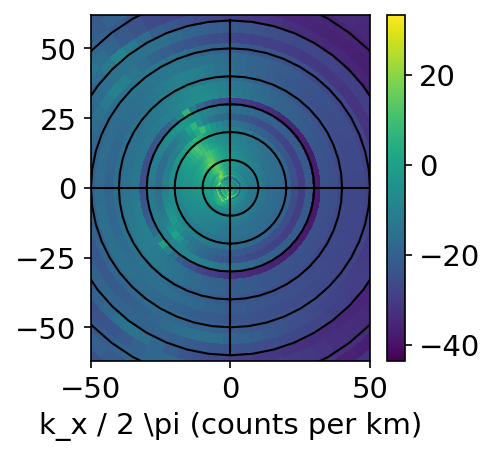

kx2D [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.24219725e-05  6.24219725e-05  6.24219725e-05 ...  6.24219725e-05
   6.24219725e-05  6.24219725e-05]
 [ 1.24843945e-04  1.24843945e-04  1.24843945e-04 ...  1.24843945e-04
   1.24843945e-04  1.24843945e-04]
 ...
 [-1.87265918e-04 -1.87265918e-04 -1.87265918e-04 ... -1.87265918e-04
  -1.87265918e-04 -1.87265918e-04]
 [-1.24843945e-04 -1.24843945e-04 -1.24843945e-04 ... -1.24843945e-04
  -1.24843945e-04 -1.24843945e-04]
 [-6.24219725e-05 -6.24219725e-05 -6.24219725e-05 ... -6.24219725e-05
  -6.24219725e-05 -6.24219725e-05]]
dx,dy: 10 10
dx,dy: 10 10
dx,dy: 10 10
dx,dy: 10 10
dx,dy: 10 10
allB (801, 801, 5)


<Figure size 1000x600 with 0 Axes>

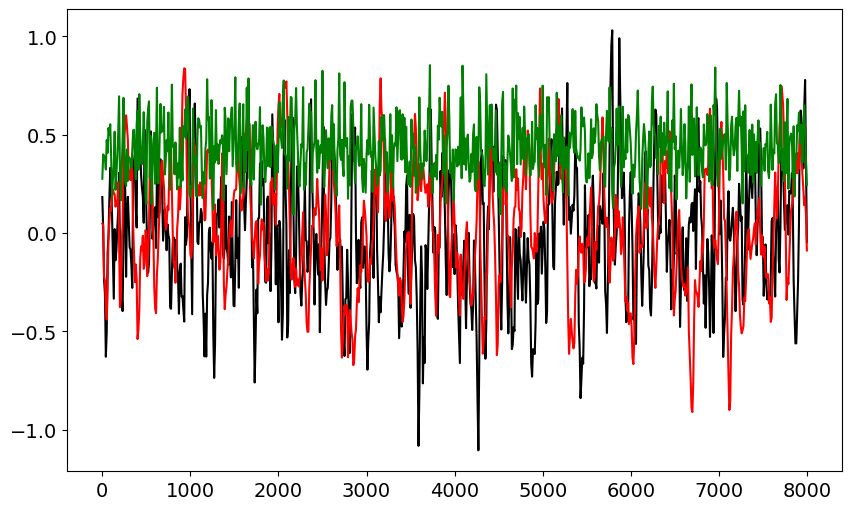

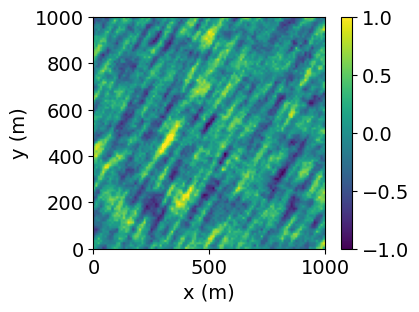

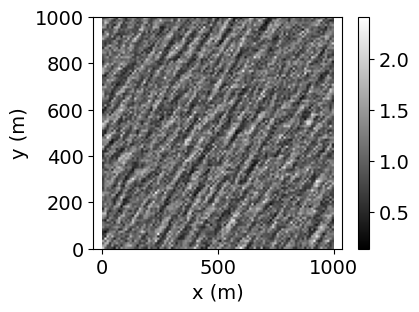

In [7]:
##################
# Parameters
##################

#   dx is pixel size       (NB: dy=dx)
#   nx is number of pixels (NB: nx=ny)
#   fac is the mean image value  
#   facr is the reflection coefficient used to impose reflections: if zero, full 2D spectrum is used
#   na: additive noise parameter

#   nt: multiplicative noise parameter
#   ntime: number of images 
#  dti: time step between images

nx=801
ny=nx
dx=10
dy=dx
iseed=0
fac=1000
facr=0
na=0
# bruit
nt=0

ntime=5
dt=4
plotb=1
U10=6
Udir=40
Ux=-1
Uy=0
betad=9.06
thetad=6.24

dfb=dfb

##################
# Using S2 simu function
##################
# [img1, img2, img3, img4, imgtimes, phitrig, nx, ny, x, y, dx, dy  ]=S2_simu(Efth0,fb,dfb,dirs,dth ,fac,facr,na,nt,ntime,dt,plotb,dx,nx,iseed,U10,Udir,Ux,Uy,betad,thetad);
[img1, img2, img3, img4, imgtimes, phitrig, nx, ny, x, y, dx, dy  ]=S2_simu(Efth,fb,dfb,dirs,dth ,fac,facr,na,nt,ntime,dt,plotb,dx,nx,iseed,U10,Udir,Ux,Uy,betad,thetad);



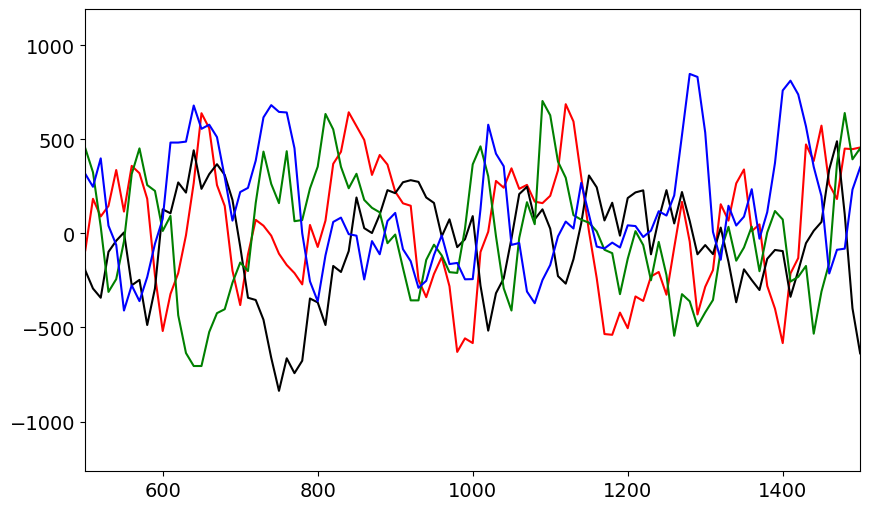

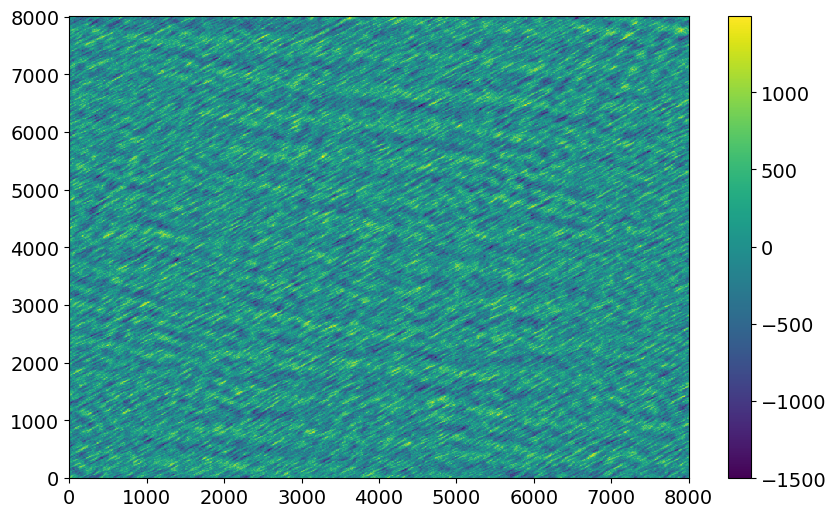

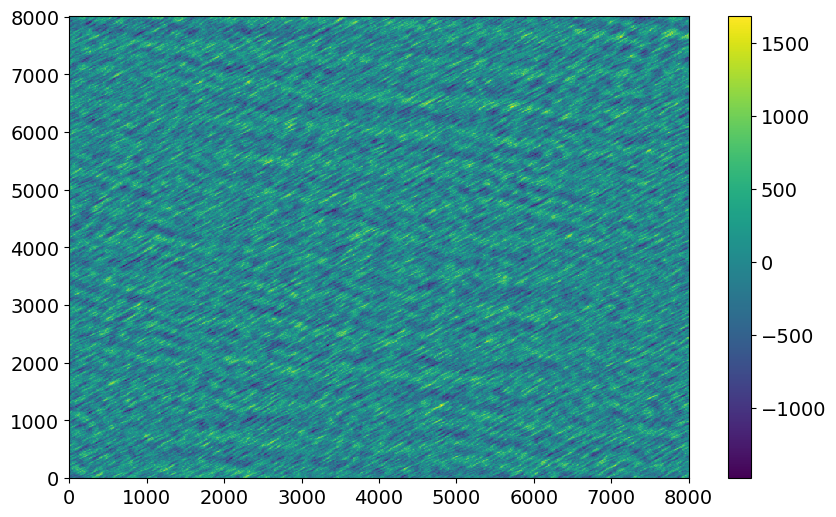

In [8]:
plt.figure(0)
plt.plot(x,img1[0,:],c='r')
plt.plot(x,img2[0,:],c='k')
plt.plot(x,img3[0,:],c='g')
plt.plot(x,img4[0,:],c='b')
plt.xlim([500,1500])
plt.figure(1)
plt.get_cmap('viridis')  # Utilisez 'gray' pour la carte de couleurs
plt.title('Wave spectrum interpolated in kx,ky plane')
plt.clf()  # Equivalent à 'clf'
    
 # Plotting convention is direction from
   # plt.pcolor(x,y, img1,vmin=0.5,vmax=3000)   #, shading='flat')
plt.pcolor(y,x, img2)  #, shading='flat')

plt.colorbar()  # Ajouter une barre de couleur

plt.figure(2)
plt.pcolor(y,x, img3)  #, shading='flat')

plt.colorbar()  # Ajouter une barre de couleur

## Current field

In [9]:
# plt.figure(1)
# plt.get_cmap('viridis')  # Utilisez 'gray' pour la carte de couleurs
# plt.title('Wave spectrum interpolated in kx,ky plane')
# plt.clf()  # Equivalent à 'clf'
# # Plotting convention is direction from
# # plt.pcolor(x,y, img1,vmin=0.5,vmax=3000)   #, shading='flat')
# plt.pcolor(y,x, img1)  #, shading='flat')
# plt.colorbar()  # Ajouter une barre de couleur
# plt.figure(2)
# plt.pcolor(y,x, img4)  #, shading='flat')
# plt.colorbar()  # Ajouter une barre de couleur


# Normalized images
# img1=img1/np.median(img1.flatten())
# img2=img2/np.median(img2.flatten())
# plt.figure(1)
# plt.get_cmap('viridis')
# plt.imshow(np.flipud(np.transpose(img3)),vmin=0.9, vmax=1.1) #edit your vmin, vmax and cmap if you don't like greyscale colormap
# # plt.imshow(np.flipud(np.transpose(img1))) #edit your vmin, vmax and cmap if you don't like greyscale colormap

# plt.colorbar()

# plt.figure(2)
# plt.get_cmap('viridis')
# plt.imshow(np.flipud(np.transpose(img2)),vmin=0.9, vmax=1.2) #edit your vmin, vmax and cmap if you don't like greyscale colormap
# plt.colorbar()

# print(img2)

### FFT

In [10]:
os.chdir('/home/acuevas/Bureau/S2_ALEXANDRA/OPTOOLS/PYTHON/Carte_courant/')
from spectral_analysis_functions import *
from S2_read import *
from s2_angs import *

In [11]:
os.chdir('/home/acuevas/Bureau/CDD_ifermer/')

(50, 50)
(50, 50)
(50, 50)
variance 1: 109715.50563566887 sum of spectrum: 106647.38077811488
variance 2: 110101.20994740065 sum of spectrum: 106323.06470696133


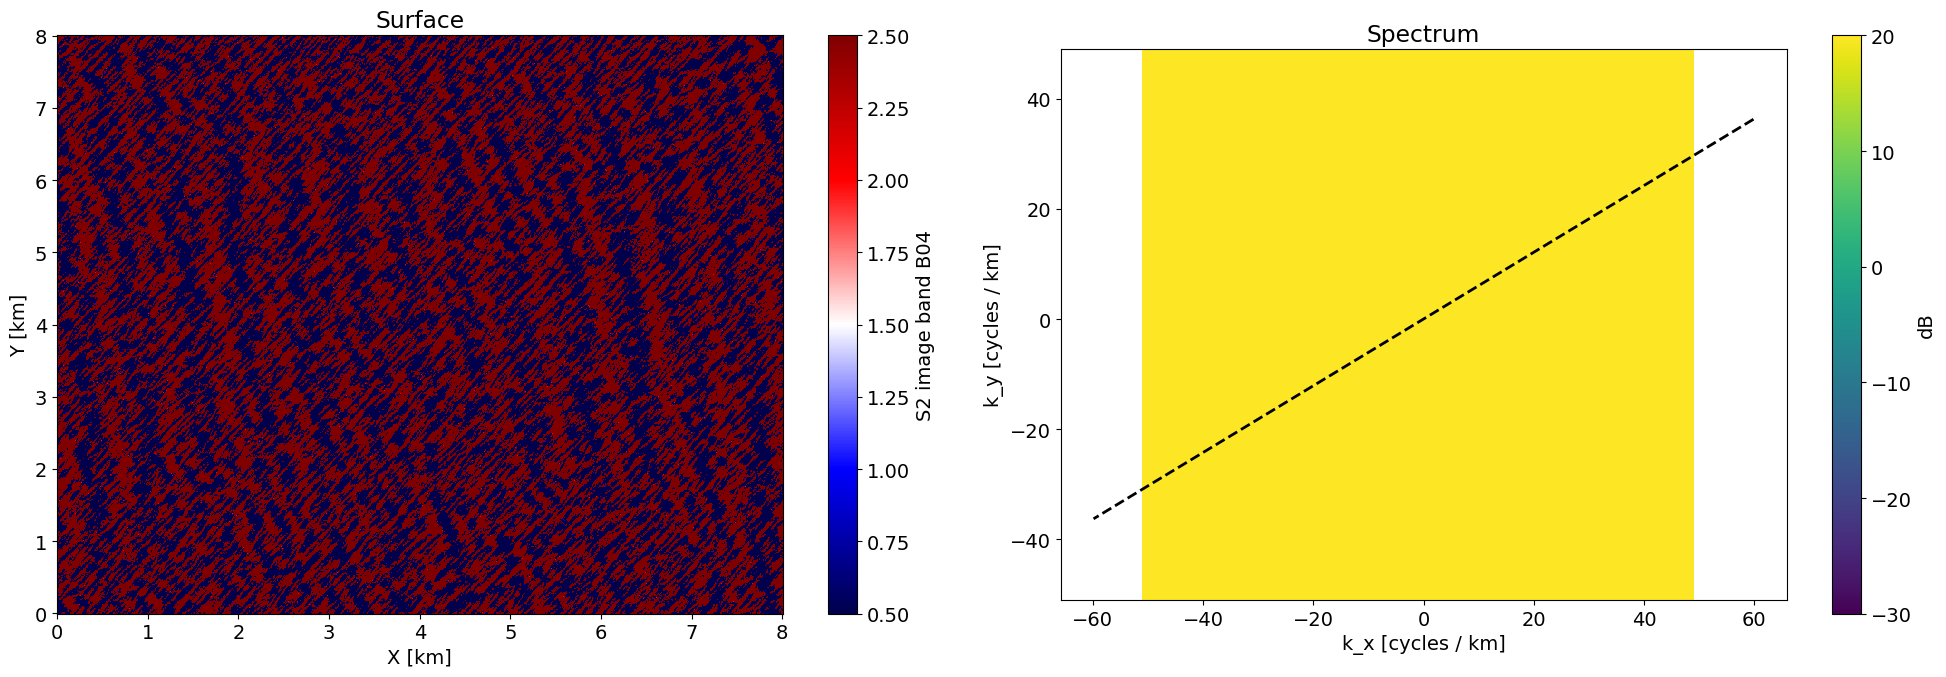

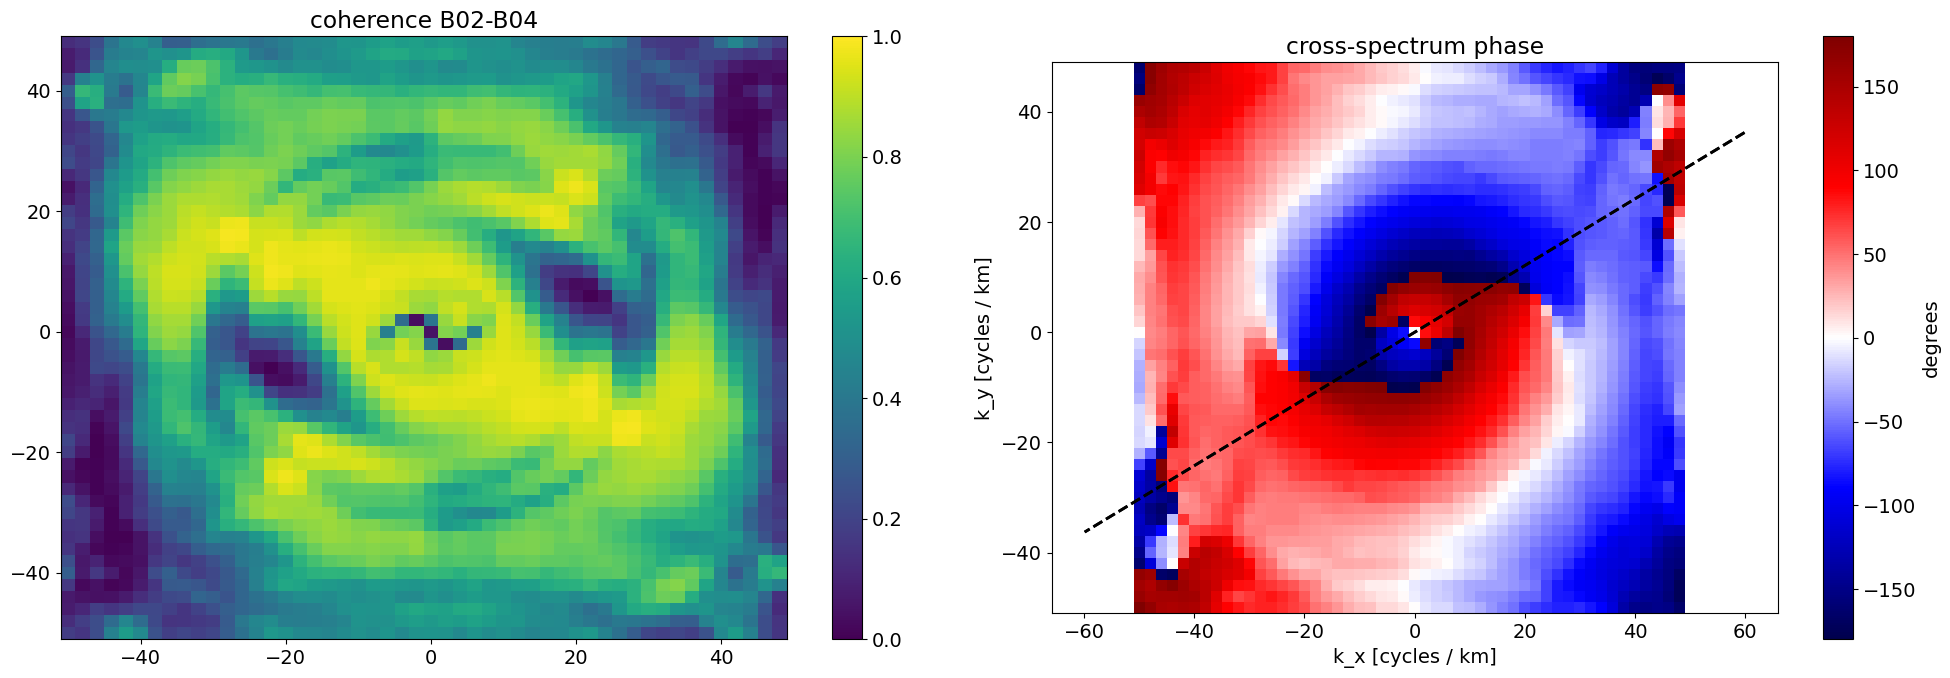

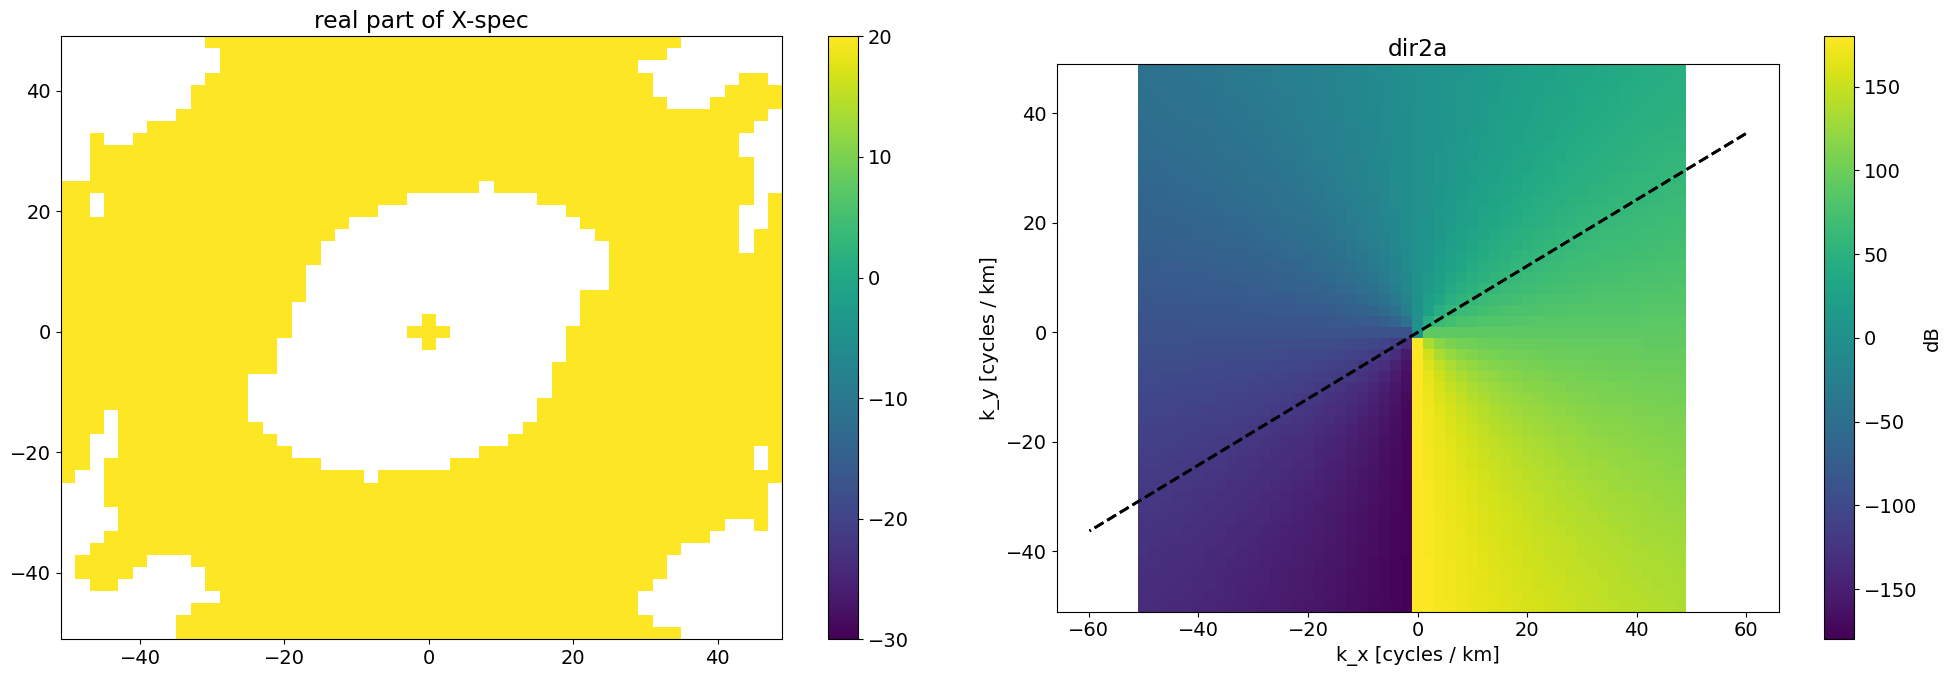

In [12]:
ntile=16
(Eta,Etb,ang,angstd,coh,crosr,phases,kx2,ky2,dkx,dky)=FFT2D_two_arrays(img2,img3,dx,dy,ntile,isplot=0)
print(np.shape(Eta))
print(np.shape(kx2))
print(np.shape(ky2))


phiblind1=phitrig[0]+90.  # blind azimuth for first band
phiblind2=phitrig[1]+90.  # blind azimuth for 3rd band
phiblind3=phitrig[2]+90.  # blind azimuth for 3rd band
kN=50
xkblind=[-1.4*kN*np.sin(np.radians(phiblind2)) , 1.4*kN*np.sin(np.radians(phiblind2))]
ykblind=[-1.4*kN*np.cos(np.radians(phiblind2)) , 1.4*kN*np.cos(np.radians(phiblind2))]


X = np.arange(0,nx*dx,dx) # from 0 to (nx-1)*dx with a dx step
Y = np.arange(0,ny*dy,dy)

fig,axs=plt.subplots(1,2,figsize=(20,7))#,sharey=True,sharex=True)
_=plt.gca().set_aspect('equal', adjustable='box')

# warning: we use an array img1 that is written with X in the first (number 0) dimension and Y in the second
#          but pcolormesh uses the opposite order: hence the use of transpose 

im=axs[0].pcolormesh(X/1000,Y/1000,np.transpose(img3),cmap='seismic',norm = mcolors.Normalize(vmin=0.5, vmax=2.5))
_=plt.colorbar(im,ax=axs[0],label='S2 image band B04')
_=axs[0].set_xlabel('X [km]')
_=axs[0].set_ylabel('Y [km]')
_=axs[0].set_title('Surface')

im=axs[1].pcolormesh(kx2*1000,ky2*1000,10*np.log10((Eta)),norm = mcolors.Normalize(vmin=-30, vmax=20))
_=plt.colorbar(im,ax=axs[1],label='dB')
_=plt.plot(xkblind,ykblind,color='k',linestyle='--',linewidth=2)
_=axs[1].set_xlabel('k_x [cycles / km]')
_=axs[1].set_ylabel('k_y [cycles / km]')
_=axs[1].set_title('Spectrum')
_=plt.tight_layout()

print('variance 1:',np.var(img3.flatten()), 'sum of spectrum:',np.sum(Eta.flatten())*dkx*dky )
print('variance 2:',np.var(img2.flatten()), 'sum of spectrum:',np.sum(Etb.flatten())*dkx*dky )


fig,axs=plt.subplots(1,2,figsize=(20,7))#,sharey=True,sharex=True)
_=plt.gca().set_aspect('equal', adjustable='box')

im=axs[0].pcolormesh(kx2*1000,ky2*1000,coh,norm = mcolors.Normalize(vmin=0, vmax=1))
_=plt.colorbar(im,ax=axs[0],label=' ')
_=plt.plot(xkblind,ykblind,color='k',linestyle='--',linewidth=2)
_=axs[1].set_xlabel('k_x [cycles / km]')
_=axs[1].set_ylabel('k_y [cycles / km]')
_=axs[0].set_title('coherence B02-B04')

im=axs[1].pcolormesh(kx2*1000,ky2*1000,np.degrees(ang),cmap='seismic',norm = mcolors.Normalize(vmin=-180, vmax=180))
_=plt.colorbar(im,ax=axs[1],label='degrees')
_=plt.plot(xkblind,ykblind,color='k',linestyle='--',linewidth=2)
_=axs[1].set_xlabel('k_x [cycles / km]')
_=axs[1].set_ylabel('k_y [cycles / km]')
_=axs[1].set_title('cross-spectrum phase')
_=plt.tight_layout()

fig,axs=plt.subplots(1,2,figsize=(20,7))#,sharey=True,sharex=True)
_=plt.gca().set_aspect('equal', adjustable='box')

im=axs[0].pcolormesh(kx2*1000,ky2*1000,10*np.log10((crosr)),norm = mcolors.Normalize(vmin=-30, vmax=20))
_=plt.colorbar(im,ax=axs[0],label=' ')
_=plt.plot(xkblind,ykblind,color='k',linestyle='--',linewidth=2)
_=axs[1].set_xlabel('k_x [cycles / km]')
_=axs[1].set_ylabel('k_y [cycles / km]')
_=axs[0].set_title('real part of X-spec')

dir2a=np.degrees(np.arctan2(kx2,ky2))
im=axs[1].pcolormesh(kx2*1000,ky2*1000,dir2a,norm = mcolors.Normalize(vmin=-180, vmax=180))
_=plt.colorbar(im,ax=axs[1],label='dB')
_=plt.plot(xkblind,ykblind,color='k',linestyle='--',linewidth=2)
_=axs[1].set_xlabel('k_x [cycles / km]')
_=axs[1].set_ylabel('k_y [cycles / km]')
_=axs[1].set_title('dir2a')
_=plt.tight_layout()


4.0


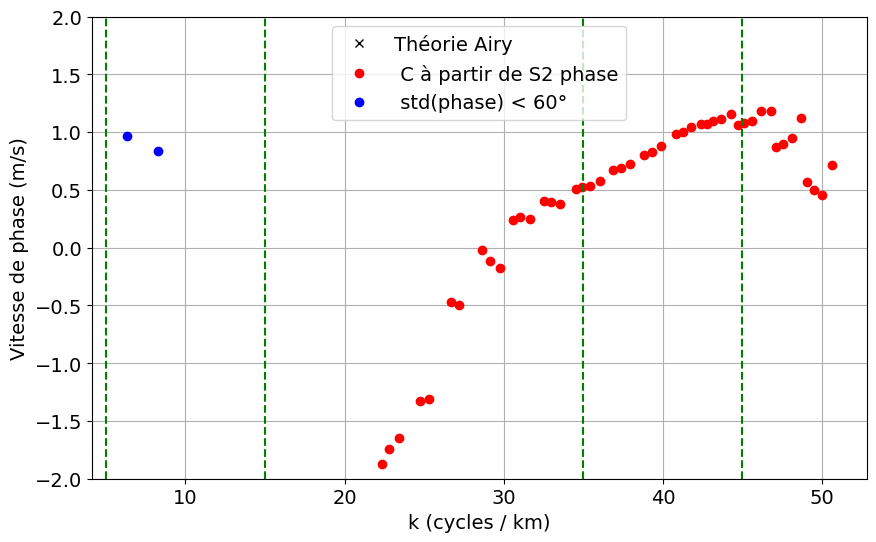

In [13]:
kn=np.sqrt(kx2**2+ky2**2)*(2*np.pi)+1E-20
kncpk=kn/(2*np.pi)*1000

# dirC1=110;dirC2=120
dirC1=100;dirC2=110
# dirC1=-70;dirC2=-60


#dt
dt=(imgtimes[2]-imgtimes[1])
print(dt)

J =np.where((coh > 0.01) & (dir2a < dirC2) & (dir2a > dirC1) & (np.degrees(angstd)  < 60) )
J2=np.where((coh > 0.01) & (dir2a < dirC2) & (dir2a > dirC1) )


dispt=np.sqrt(9.81/kn)
Cimg=ang/kn/dt
Cstd=angstd/kn/abs(dt)

#En français
plt.plot(kn[J]/(2*pi)*1000,dispt[J],'kx',linewidth=3,label='Théorie Airy') 
plt.plot(kn[J2]/(2*pi)*1000,-Cimg[J2],'ro',linewidth=1,label=' C à partir de S2 phase')
plt.plot(kn[J]/(2*pi)*1000,-Cimg[J]-dispt[J],'bo',linewidth=1,label=' std(phase) < 60°') 
# plt.plot(kn[J]/(2*pi)*1000,-Cimg[J],'bo',linewidth=1,label=' std(phase) < 60°') 


# Ajout des lignes verticales sans labels
plt.axvline(x=5, color='g', linestyle='--')
plt.axvline(x=15, color='g', linestyle='--')
plt.axvline(x=35, color='g', linestyle='--')
plt.axvline(x=45, color='g', linestyle='--')

plt.grid(True)
plt.xlabel('k (cycles / km)')
plt.ylabel('Vitesse de phase (m/s)')
plt.ylim([-2,2])
plt.legend()


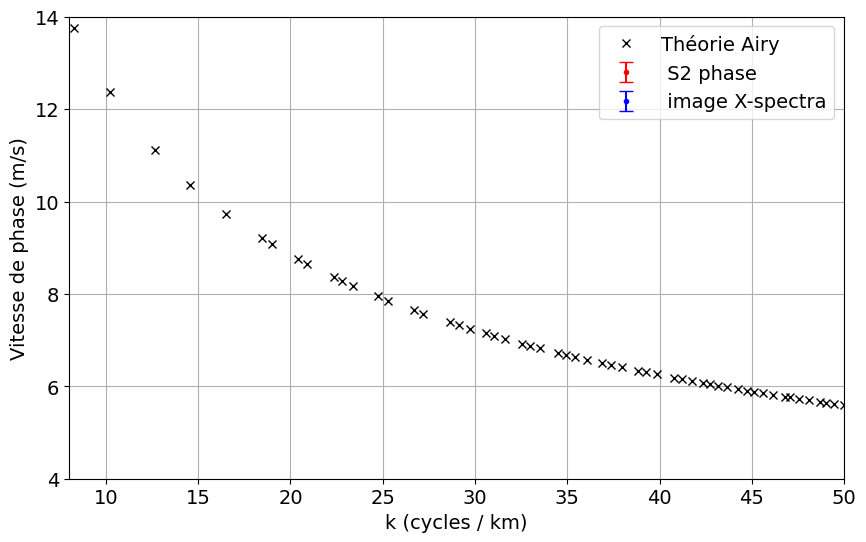

In [14]:
plt.errorbar(kn[J2]/(2*np.pi)*1000,-Cimg[J2],yerr=Cstd[J2]/16,fmt='.r',capsize=5,label=' S2 phase')
plt.errorbar(kn[J]/(2*np.pi)*1000,-Cimg[J],yerr=Cstd[J]/16,fmt='.b',capsize=5,label=' image X-spectra')
plt.plot(kn[J2]/(2*np.pi)*1000,dispt[J2],'kx',linewidth=3,label='Théorie Airy') 
plt.grid(True)
plt.axis([8,50,4,14])
plt.xlabel('k (cycles / km)')
plt.ylabel('Vitesse de phase (m/s)')
plt.legend()
plt.show()


U and V components of current : [-0.90161058 -0.25795711]
Current intensity: 0.9377864933858944
uncertainties for U and V: 0.4182993144103313 0.3838740071423436


Text(0, 0.5, '$K_y$ ')

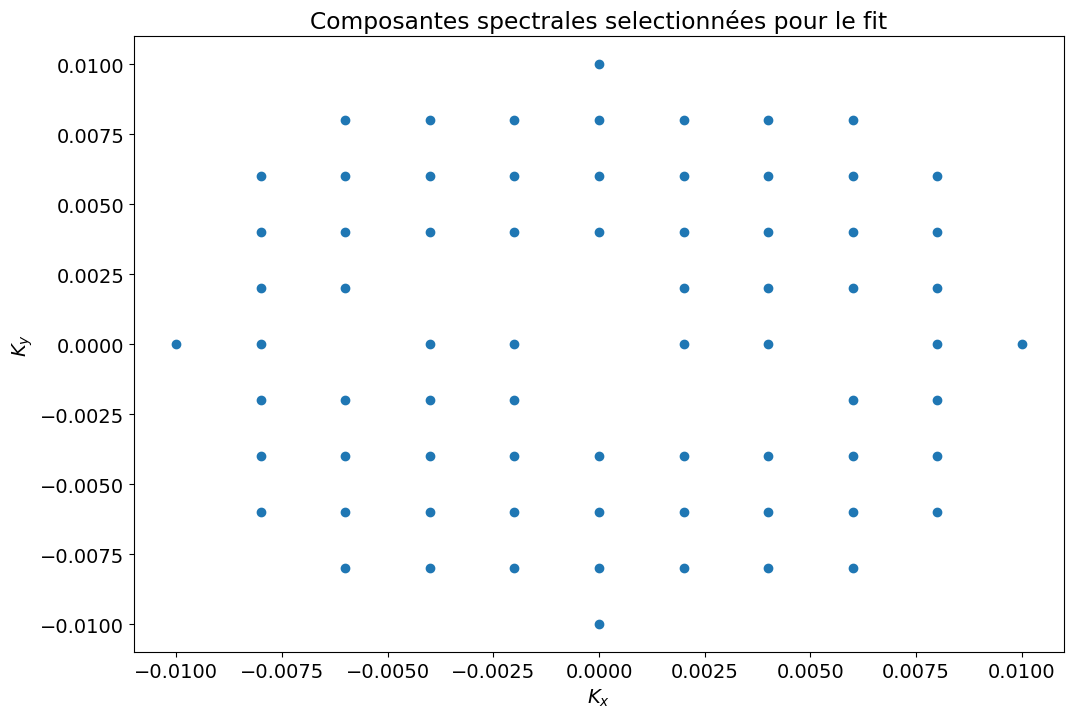

In [15]:
d2r=np.pi/180
phase_o = abs(dt) * np.sqrt(9.81 * kn)  # phase from linear theory (deep water)
phase_diff=ang-phase_o*np.sign(ang)# phase_diff should be equal to kx.Ux + ky.Uy ...
k_min_fit = 0# in cpk
k_max_fit = 10# in cpk
std_max = 60*d2r
# id_fit = np.where((angstd / d2r < std_max) & (kncpk >= k_min_fit) & (kncpk <= k_max_fit))  # & phase > 0

# id_fit = np.where((angstd.flatten()  < std_max)  & (kncpk.flatten() >= k_min_fit) & (kncpk.flatten() <= k_max_fit)&(coh.flatten()**2>0.60) )[0]  # & phase > 0
id_fit = np.where((angstd.flatten()  < std_max)  & (kncpk.flatten() >= k_min_fit) & (kncpk.flatten() <= k_max_fit))[0]  # & phase > 0
angstd=angstd.flatten()
phase_diff=phase_diff.flatten()
weight = ntile**2 / (angstd[id_fit] ** 2)/dt**2

kx1=kx2.flatten()
ky1=ky2.flatten()
K_x_fit = kx1[id_fit]
K_y_fit = ky1[id_fit]
Y2 = phase_diff[id_fit] / dt

C=np.diag(weight)
A=(np.column_stack((K_x_fit,K_y_fit)))*(2*np.pi)

# X=np.linalg.lstsq(A,Y2, rcond='warn')   
# print('U and V components of current :',X[0])
# Pondération 

ATC=np.matmul(A.T,C)
D=np.matmul(ATC,A)
#print('A:',A)
DI=np.linalg.inv(D)


X=np.matmul(DI,np.matmul(ATC,Y2))
print('U and V components of current :',X)
Cmag=np.sqrt(X[0]**2+X[1]**2)
print('Current intensity:',Cmag)

sigU=np.sqrt(abs(DI))
print('uncertainties for U and V:',sigU[0,0],sigU[1,1])

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(K_x_fit, K_y_fit)
ax.set_title('Composantes spectrales selectionnées pour le fit')
ax.set_xlabel('$K_x$ ')
ax.set_ylabel('$K_y$ ')

## Test avec 3 images